In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

/Users/kushcoshic/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This code returns **effectively independent samples** for a distribution, using a Metropolis-MCMC simulation. There is an inherent correlation within samples in any Markov-chain based simulation, and using effectively independent samples gives a better sense of the distribution with relatively small number of samples; improving on computational efficiency for subsequent analysis.

The Metropolis-MCMC simulation keeps running till the Markov-chains achieve approximate convergence, and the required number of independent samples (specified by us) have been drawn. The algorithm is based on the discussion given by Andrew Gelman in his book (Bayesian Data Analysis). We start by running multiple MCMC chains around the posterior (that we want to sample), and check for approximate convergence by running till the autocorrelations fall to a specifiable choice (Potential Scale reduction factor, $R<1.1$). Since we have multiple chains, the overall sample variance should reflect the **between** and **within** chain variance, which is based on the discussion given in the book (Chapter 11).

This example considers a multivariate normal distribution, of dimension $k (=2)$. 

$f(x)$ gives its general functional form:

\begin{equation}
\boxed{f(x) = (2\pi)^{-\frac{k}{2}}| \mathbf{\Sigma} |^{- \frac{1}{2}} e^{- \frac{1}{2}\ (x-\mu)\prime \ \mathbf{\Sigma}^{-1}\ (x-\mu )}\ \ , \ \ \ k\equiv dimension}
\end{equation}

- $x$ denotes a general k dimensional vector
- $|\Sigma |$ denotes determinant of the Covariance matrix
- $\mu$ denotes the k dimensional, maxima of the distribution

In [2]:
# This array contains the starting points to be used for the Markov chains
x_start = np.array([[0.,0.],[-0.9,0.9],[-0.9,-0.9],[0.9,-0.9],[0.9,0.9]]) 

# Everywhere in the code I refer the term dimension to the coordinates in vector space defined by the vectors x
dimension = len(x_start[0])


# f(x)
# Multivariate Normal distribution
# x0,x1 are the 2 gaussian maxima's
x0=np.matrix([2.5,2.5])
#x1=np.matrix([-2.5,2.5])

# cov is the covariance matrix of the bivariate distribution we need to sample
cov=np.matrix([[1.,3./5],[3./5,2.]])
det=np.linalg.det(cov)
inv=np.linalg.inv(cov)

k=dimension       # dimension

# The distribution that needs to be sampled
def f(x):
    x=np.ravel(x)
    x=np.matrix(x)
    return (((2*np.pi)**(-k/2.))*((det)**(-1/2))*np.exp(-(1./2)*(x-x0)*inv*(x-x0).T))


In [3]:
n_eff_list = []
mcmc_step_list = []
n_eff_list_y = []

# Defining a function stepper(x) that returns a random vector around x
# The stepper parametrizes the jumping distribution for the Metropolis MCMC simulation
covv=1.5*cov              # covariance matrix for the stepper function
mean=[0.,0.]              # mean vector for the stepper function

def stepper(x):
    x=np.ravel(x)
    dx = np.random.multivariate_normal([0.,0.], covv, 1)
    return x+dx


# Parameters to be entered by the user
n_eff_min = 1000           # minimum number of effective samples required

# mcmc_step needs to be a multiple of 4 (because of warm-up and subsequent slicing into 2 arrays)
mcmc_step = 1000          # MCMC iterations step-size
R_max = 1.1               # maximum allowed value for R, (Potential scale reduction factor)

# used to make sure the simulation keeps running till autocorrelation reaches zero, which might not be the case for a small n_eff_min value given by the user.
choice = dimension*['']

Description of the algorithm:

- The function **run_mcmc** executes the mcmc sampling, subsequent autocorrelation computations, confirming approximate convergence, and computing the final set of independent samples.

- The while loop keeps running till:
        - number of independent samples obtained are atleast equal to n_eff_min
        - R < R_max
        - The 3rd condition helps avoid the autocorrelation error (when enough MCMC iterations are not done so that the autocorrelation never reaches zero)

- For loop [Line 27], generates the mcmc samples for each dimension; and records the data in x_recorded
- warming up discards 1st half of the data in x_recorded and stores in x_warmup
- Every chain is split into 2 and made seperate chains (in our example the total chains change from 5 to 10). These are the final mcmc samples to be used for extracting independent samples, and are recorded into x_result
- All variables like psi_dot_j_bar, psi_dot_dot_bar etc. follow exactly as described in the book.
- I have initially assigned each of these as a null array [ ], and append() values for each dimension/coordinate
- All functions, such as variance, var_dagger, variogram, autocorrelation etc. have been defined and implemented accordingly, as mentioned in the book
- Inside the while loop is a for loop (in the variable d) that computes for each of the coordinates (=dimension) the functions defined below,
- For each scalar estimand $\psi$, we label the simulations as $\psi_{ij}(i=1,...,n;j=1,...,m)$ and compute **B** and **W**, the Between- and Within -sequence variances:

\begin{equation}
B=\frac{n}{m-1} \sum_{j=1}^{m}(\bar{\psi_{.j}} - \bar{\psi_{..}})^2 \ , \ \ \ where \ \ \bar{\psi_{.j}} = \frac{1}{n}\sum_{i=1}^{n} \psi_{ij} \ , \ \ \ \ \bar{\psi_{..}}=\frac{1}{m}\sum_{j=1}^{m}\bar{\psi_{.j}}
\end{equation}

\begin{equation}
W = \frac{1}{m}\sum_{j=1}^{m} s_{j}^2 , \ \ where \ s_{j}^2 = \frac{1}{n-1}\sum_{i=1}^{n} (\psi_{ij} - \bar{\psi_{.j}})^2
\end{equation}

\begin{equation}
\hat{var}^{+} (\psi | y)=\frac{n-1}{n} W + \frac{1}{n} B
\end{equation}

\begin{equation}
\hat{R} = \sqrt{\frac{\hat{var}^{+} (\psi | y)}{W}}
\end{equation}

- An estimate of the effective sample size is obtaines from the asymptotic formula for the variance of the average of a correlated sequemce:

\begin{equation}
lim_{n \rightarrow \infty} mn \ var(\bar{\psi_{..}}) = \big( 1+2\sum_{t=1}^{\infty} \rho_{t} \big) var(\psi |y)
\end{equation}

where $\rho_{t}$ is the autocorrelation of the sequence $\psi$ at lag t.

- If the n simulation draws from each of the m chains were independent, then $var(\bar{\psi_{..}})$ would simply be $\frac{1}{mn} var(\psi |y)$ and the sample size would be mn. However in the presence of correlation we can define the **effective sample size** as:

\begin{equation}
n_{eff} = \frac{mn}{1+2\sum_{t=1}^{\infty} \rho_{t}}
\end{equation}

- Unfortunately, simply summing all of the autocorrelations to estimate $n_{eff}$ will have the sample correlation too noisy for large values of t. Therefore we compute a partial sum, starting from lag0 and continuing until the sum of autocorrelation estimates for 2 successive lags $\hat{\rho}_{2t'}+\hat{\rho}_{2t'+1}$ is negative; where

\begin{equation}
\hat{n}_{eff} = \frac{mn}{1+2\sum_{t=1}^{T} \hat{\rho_{t}}}
\end{equation}

where T is the first odd positive integer for which $\hat{rho}_{T+1} + \hat{rho}_{T+2}$ is negative

-Now to get the set of effectively independent samples, we draw samples from x_result, but skipping every $\frac{mn}{n_{eff}}$ samples in between. Finally we record the final set of independent samples in **samples**

In [4]:
def run_mcmc(f,x_start,stepper,n_eff_min,R_max,mcmc_step):
    n_effective = np.zeros(dimension)
    n_eff_min_list = np.zeros(dimension)
    acceptance_list=[]
    for i in range(dimension):
        n_eff_min_list[i] = n_eff_min
    R_max_list = np.zeros(dimension)
    for i in range(dimension):
        R_max_list[i] = R_max
    
    z=0
    R=0
    mcmc_step_remember = mcmc_step
    x_recorded = np.zeros((mcmc_step,dimension,len(x_start)))

    while (np.any(np.array(n_effective)<n_eff_min_list) or np.any(R>R_max_list) and all([i=='' for i in choice])):
        # MCMC results stored in a 3-d array, 3rd dimension corresponding to every new chain
        #choice = dimension*['']
        if z==0:                         # this if else is there to make sure the samples from the previous run are not wasted
            mcmc_step_0=0
            x_recorded = np.zeros((mcmc_step,dimension,len(x_start)))
        else:
            x_recorded_template = np.zeros((mcmc_step,dimension,len(x_start)))         # this if-else is used to store the already computed MCMC samples, before moving to further iterations (if n_eff condition not satisfied). This prevents unecessary wastage of computational power.
            x_recorded_template[:mcmc_step_0,:,:]=x_recorded[:,:,:]
            x_recorded = x_recorded_template
        for i in range(len(x_start)):
            x_current = x_start[i]
            acceptances = np.zeros(mcmc_step)
            for k in range(mcmc_step_0,mcmc_step):
                x_new = stepper(x_current)
                if np.random.uniform(0,1) < f(x_new)/f(x_current):
                    x_current = x_new
                    acceptances[k] = 1
                x_recorded[k,:,i] = x_current
            acceptance_list.append(1.0*acceptances.sum()/len(acceptances))
            #print 'acceptance fraction = %f'%(1.0*acceptances.sum()/len(acceptances))

        # Warm up period (extracting only second half of the iterations)
        x_warmup = np.zeros((mcmc_step/2,dimension,len(x_start)))
        x_warmup[:,:,:] = x_recorded[mcmc_step/2:,:,:]
        #plt.plot(x_warmup[:,0,:],x_warmup[:,1,:],'.',color='b')

        # Splitting the chains
        x_result = np.zeros((mcmc_step/4,dimension,2*len(x_start)))
        x_result[:,:,0:len(x_start)] = x_warmup[0:mcmc_step/4,:,:]
        x_result[:,:,len(x_start):2*len(x_start)] = x_warmup[mcmc_step/4:mcmc_step/2,:,:]
        
        
        n=mcmc_step/4.0         # number of iterations in each chain
        m=2.0*(len(x_start))    # number of chains

        
        # Assessing mixing using between and within sequence variances

        psi = []
        for i in range(dimension):
            psi.append(x_result[:,i,:])
        psi = np.array(psi)
        # this was done to divide the data for each dimension, for convenience
        
        psi_dot_j_bar = []
        psi_dot_dot_bar = []
        B_term = []
        B = []                                    # Between sequence variance
        s_j_square_term = []
        s_j_square = []
        W = []                                    # Within sequence variance
        var_dagger = []
        R = []
        psi_i_comma_j = []
        psi_i_minus_t_comma_j = []
        
        rho_array_set = []
        t_array_set = []
        n_effective_list = []
        t_array = np.arange(int(n))
        
        
        # for every subsequent dimension the values are appended into the arrays
        for d in range(dimension):
            psi_dot_j_bar.append((1/n)*np.sum(psi[d], axis=0))
            
            psi_dot_dot_bar.append((1/m)*np.sum(psi_dot_j_bar[d]))
            
            B_term.append(psi_dot_j_bar[d] - psi_dot_dot_bar[d])
            
            B.append((n/(m-1.0))*np.sum(B_term[d]**2))

            s_j_square_term.append(np.zeros((int(n),int(m))))
            
            for j in range(int(m)):         # performing for all chains
                s_j_square_term[d][:,j] = (psi[d][:,j] - psi_dot_j_bar[d][j])**2.0

            s_j_square.append((1.0/(n-1))*np.sum(s_j_square_term[d], axis=0))
            
            W.append((1.0/(m))*np.sum(s_j_square[d]))
            

            # variance
            var_dagger.append(((n-1)/(n))*W[d] + (1/n)*B[d])
            
            #var_dagger

            # potential scale reduction
            R.append(np.sqrt(var_dagger[d]/W[d]))
            
            #R
            # Variogram
            def V(t):
                psi_i_comma_j = psi[d][t+1-1:,:]
                
                psi_i_minus_t_comma_j = psi[d][0:int(n)-t,:]
                
                t=float(t)
                return (1.0/(m*(n-t)))*np.sum(np.sum((psi_i_comma_j - psi_i_minus_t_comma_j)**2.0,axis=0))
            
            # autocorrelation
            def rho(t):
                return 1.0-(V(t)/(2.0*var_dagger[d]))
            
            
            rho_array=np.zeros(int(n))
            for t in range(int(n)):
                rho_array[t]= rho(int(t))
            rho_array_set.append(rho_array)
            # checking where the autocorrelation goes to zero for the first time, append that iteration number in choice array for every subsequent dimension
            # The while loop in the beginning, makes the code run until all k (=dimension) elements in choice[] are not null, which implies autocorrelation reached zero for each of them.
            for i in range(int(n)):
                check = rho(i) + rho(i+1)
                if check < 0:
                    #choice.append(i*1.0)
                    choice[d]=i*1.0
                    break
            
            # if choice[d] is not null, autocorrelation did reach zero and we could use the corresponding iteration number to calculate the value for n_effective obtained for the simulation
            if choice[d] != '':
                # effective sample size
                n_effective[d]=(m*n)/(1+2.0*np.sum(rho_array[1:choice[d]]))
            else:
                break
        
        mcmc_step_0 = mcmc_step                     # record current number of mcmc runs in mcmc_step_0, for the next run
        mcmc_step += mcmc_step_remember             # increase number of mcmc runs to be performed next in the next while loop run
        z += 1.0                                    # to keep track of the number of while loop runs (=z after run_mcmc ends)
        
    
    # Taking the minimum value for n_effective 
    n_effective_final = np.amin(n_effective)
    
    # no. of samples to be skipped before recording the next independent sample
    samples_skip = 1.0*x_result.shape[2]*x_result.shape[0]/n_effective_final
    samples_skip=np.ceil(samples_skip)
    
    # extract and store independent samples in samples_final 
    if int(x_result.shape[0]/samples_skip)==x_result.shape[0]/samples_skip:
        samples_final = np.zeros((int((x_result.shape[0])/samples_skip),x_result.shape[1],x_result.shape[2]))
    else:
        samples_final = np.zeros((int(np.ceil((x_result.shape[0])/samples_skip)),x_result.shape[1],x_result.shape[2]))
    # Broadcasting independent samples into samples_final
    samples_final[:,:,:] = x_result[0::samples_skip,:,:]
    # note that at this point the simulation data from each chain is recorded separately, it will be condensed in samples,
    
    # putting all points of different chains into 1 single array which can be referred to as the final array of our independent samples
    samples = np.zeros((samples_final.shape[0]*samples_final.shape[2],dimension))
    for i in range(samples_final.shape[2]):
        samples[i*samples_final.shape[0]:(i+1)*samples_final.shape[0],:]=samples_final[:,:,i]
    
    return n_effective,R,z,x_recorded.shape,x_result.shape,x_result,samples_final,samples,acceptance_list,x_recorded,choice


run = run_mcmc(f,x_start,stepper,n_eff_min,R_max,mcmc_step)




/Users/kushcoshic/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:138: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kushcoshic/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:160: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
samples_final=run[6]

samples_final_mean = np.zeros(dimension)
samples_final_mean_variance = np.zeros(dimension)
for i in range(len(samples_final_mean)):
    samples_final_mean[i] = np.mean(samples_final[:,i,:])                           # sample mean
    samples_final_mean_variance[i] = np.var(samples_final[:,i,:])                   # sample variance
    
#print samples_final_mean,samples_final_mean_variance
variance = (samples_final_mean_variance[0]**2.0 + samples_final_mean_variance[1]**2.0)**(1/2.0)
#print variance


In [14]:
# # Autocorrelation plots in the final set of effectively independent samples
# As we should expect, the autocorrelation plot should stay around the zero value (whichi it does perfectly if mcmc_step is taken large)

# Define for convenience
n = samples_final.shape[0]*1.0                   # no. of iterations for every chain
m = samples_final.shape[2]*1.0                   # no. of final chains
sample_x = samples_final[:,0,:]                  # samples x-dimension data
sample_y = samples_final[:,1,:]                  # samples y-dimension data



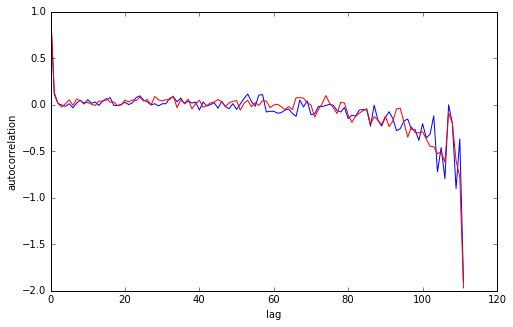

In [16]:
def V(t):                                        # same as defined inside run_mcmc
    sample_x_i_comma_j = sample_x[t+1-1:,:]
    sample_x_i_minus_t_comma_j = sample_x[0:int(n)-t,:]
    t=float(t)
    return (1/(m*(n-t)))*np.sum(np.sum((sample_x_i_comma_j - sample_x_i_minus_t_comma_j)**2.0,axis=0))

def rho(t):                                      # same as defined inside run_mcmc
    return 1-(V(t)/(2.0*samples_final_mean_variance[0]))

rho_array = np.zeros(int(n))
t_array = np.arange(int(n))

for t in range(int(n)):
    rho_array[t]= rho(int(t))                   # array containing rho values for the x coordinate
    

# Doing the same for the y-coordinate
def V_y(t):                                     # the same as above, but for the y coordinate
    sample_y_i_comma_j = sample_y[t+1-1:,:]
    sample_y_i_minus_t_comma_j = sample_y[0:int(n)-t,:]
    t=float(t)
    return (1/(m*(n-t)))*np.sum(np.sum((sample_y_i_comma_j - sample_y_i_minus_t_comma_j)**2.0,axis=0))

def rho_y(t):
    return 1-(V_y(t)/(2.0*samples_final_mean_variance[1]))

rho_array_y = np.zeros(int(n))
t_array = np.arange(int(n))

for t in range(int(n)):
    rho_array_y[t]= rho_y(int(t))              # array containing rho values for the y coordinate
    
    
plt.figure(2,figsize=(8,5))
plt.plot(t_array,rho_array,'-',color='b')                    # autocorrelation plot for x coordinate
plt.plot(t_array,rho_array_y,'-',color='r')                  # autocorrelation plot for y coordinate
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# The 2 curves seem correlated which it should since f(x) has the 2 coordinates correlated. 
# If f(x) had the 2 coordinates independent then this sort of curve could have meant some issue with the code

In [8]:
# Checking how close the covariance matrix obtained from the independent samples is to what's defined in f(x)
np.allclose(np.cov(run[7].T),cov,.06,.06)

True

In [9]:
# covariance matrix calculated from the samples
np.cov(run[7].T)

array([[ 1.05984907,  0.6769533 ],
       [ 0.6769533 ,  2.04146005]])